In [1]:
from src.data import load_data
from src.models import util_model
from src.data import util

/Users/suphanat/Documents/transOCR


FileNotFoundError: [Errno 2] No such file or directory: '../../data/model/yolo/front-model.pt'

In [ ]:
image_name = "trans020" 
front_image_name = image_name + "-1"
back_image_name = image_name + "-2"
front_image_path = "data/raw/front"
back_image_path = "data/raw/back"
front_image = load_data.read_image(front_image_path, front_image_name)
back_image = load_data.read_image(back_image_path, back_image_name)

In [ ]:
front_section_dict = util_model.detect_section(front_image, util_model.front_model)
pf_sections = util.pre_process(front_section_dict)
front_text_dict = util_model.images_to_texts(pf_sections)
courses_df = util.make_course(front_text_dict)
error_df = util.get_error(courses_df)
error_df


0: 640x480 3 sections, 891.0ms
Speed: 2.9ms preprocess, 891.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


TesseractError: (1, 'Warning: TESSDATA_PREFIX .../data/model/tesseract/build/tessdata does not exist, ignore it Error opening data file /usr/local/share/tessdata/thnd.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'thnd\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [ ]:
post_courses_df = util.post_process(courses_df, pf_sections)
post_error_df = util.get_error(post_courses_df).reset_index(drop=True)
post_error_df

,ocr,numeric,section,id,name,unit,grade


In [ ]:
# util_model.get_ocr_text(pf_sections[2]).split('\n')

In [ ]:
back_section_dict = util_model.detect_section(back_image, util_model.back_model)
pb_sections = util.pre_process(back_section_dict)
back_text_dict = util_model.images_to_texts(pb_sections)
gpa = util.get_GPA(back_text_dict[0])
gpa


0: 640x480 1 section, 879.9ms
Speed: 3.0ms preprocess, 879.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


,ocr,category,unit,grade
0,กก ภาษาไทย ...,ภาษาไทย,5.000,3.60
1,กข คณิตศาสตร์ 16.5 3.87,คณิตศาสตร์,16.500,3.87
2,กข วิทยาศาสตร์และเทคโนโลยี 30.0 ...,วิทยาศาสตร์,30.000,3.49
3,กค ' สังคมศึกษา ศาสนา และวัฒนธรรม 6.5 3.65,สังคมศึกษา,6.500,3.65
4,กค ' สุขศึกษาและพลศึกษา ...,สุขศึกษา,2.500,4.00
5,กม ศิลปะ ...,ศิลปะ,3.500,4.00
6,กง การงานอาชีพ ...,การงานอาชีพ,2.000,3.75
7,กจ ภาษาต่างประเทศ 10...,ภาษาต่างประเทศ,10.000,3.55
8,กฉ การศึกษาค้นคว้าด้วยตนเอง (5) 1.5 4.00,ศึกษาค้นคว้าด้วยตนเอง,1.500,4.00
9,กช ผลการเรียนเฉลี่ยตลอดหลักสูตร 77.5 3.65,ผลการเรียน,0.775,3.65


In [ ]:
front_edf = post_courses_df[["section", "id", "name", "unit", "grade"]]
back_edf = gpa[["category", "unit", "grade"]]

In [ ]:
front_edf

,section,id,name,unit,grade
0,000,ท33101,ภาษาไทย,1.0,3.5
1,001,ส33101,สังคมศึกษา,1.0,3.0
2,002,ส33102,ประวัติศาสตร์ไทย,0.5,2.5
3,003,พ33103,สุขศึกษาและพลศึกษา,0.5,4.0
4,004,ศ33101,ศิลปะ,0.5,4.0
...,...,...,...,...,...
72,225,ว30261,การออกแบบและเทคโนโลยี,1.0,4.0
73,226,ว32202,ฟิสิกส์,1.5,2.5
74,227,ว32222,เคมี,1.0,4.0
75,228,ว32242,ชีววิทยา,1.5,3.0


In [ ]:
back_edf

,category,unit,grade
0,ภาษาไทย,5.000,3.60
1,คณิตศาสตร์,16.500,3.87
2,วิทยาศาสตร์,30.000,3.49
3,สังคมศึกษา,6.500,3.65
4,สุขศึกษา,2.500,4.00
5,ศิลปะ,3.500,4.00
6,การงานอาชีพ,2.000,3.75
7,ภาษาต่างประเทศ,10.000,3.55
8,ศึกษาค้นคว้าด้วยตนเอง,1.500,4.00
9,ผลการเรียน,0.775,3.65


In [ ]:
load_data.export_df_to_csv("data/out/csv/front", front_image_name, front_edf)
load_data.csv_to_json("data/out/json/front", "data/out/csv/front", front_image_name)
load_data.export_df_to_csv("data/out/csv/back", back_image_name, back_edf)
load_data.csv_to_json("data/out/json/back", "data/out/csv/back", back_image_name)

In [ ]:
bb = util_model.get_lines_pos(pf_sections[0])

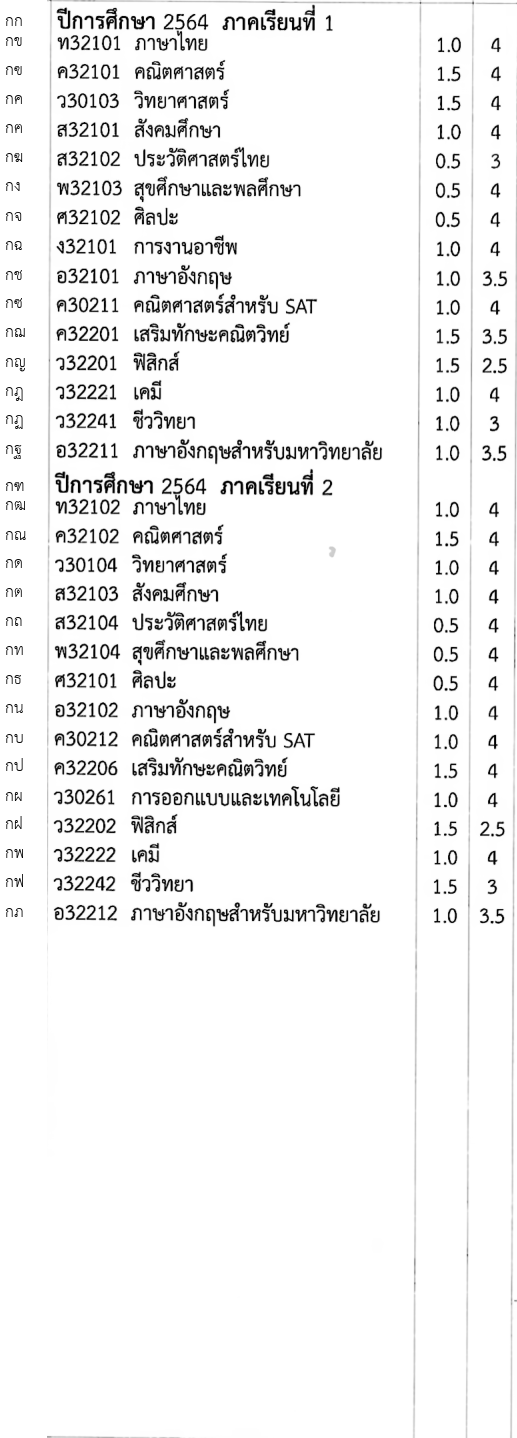

In [ ]:
pf_sections[2]

In [ ]:
import pandas as pd

In [ ]:
d = pd.DataFrame({"A": [1, 2, 3, 4],
                  "B": [1, 2, 3, 4]
                  }
)

In [ ]:
(d.A - d.A.shift(1)).abs().fillna(0)

0    0.0
1    1.0
2    1.0
3    1.0
Name: A, dtype: float64